In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
import os
base_dir = '/content/drive/MyDrive/flowers'
print(os.listdir(base_dir))

Mounted at /content/drive
['sunflower', 'rose', 'tulip', 'daisy', 'dandelion']


In [2]:
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 4317


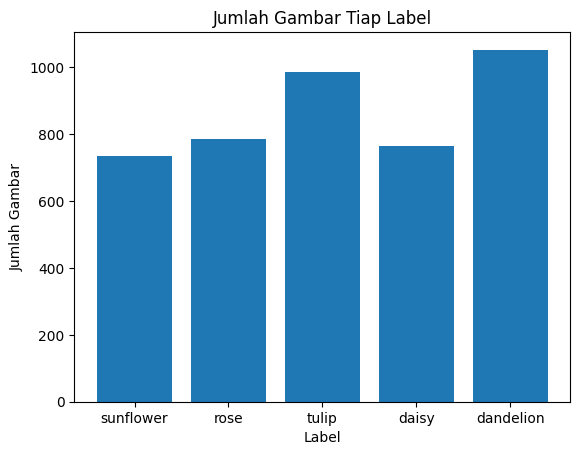

In [3]:
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

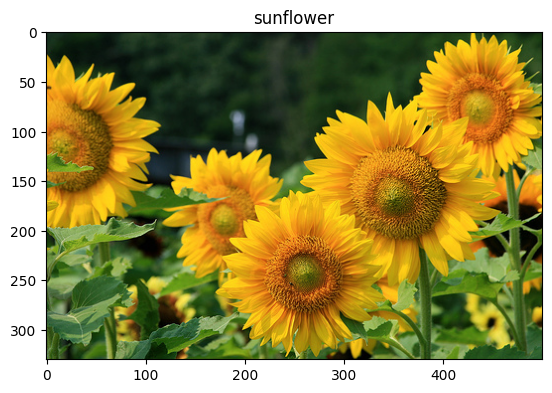

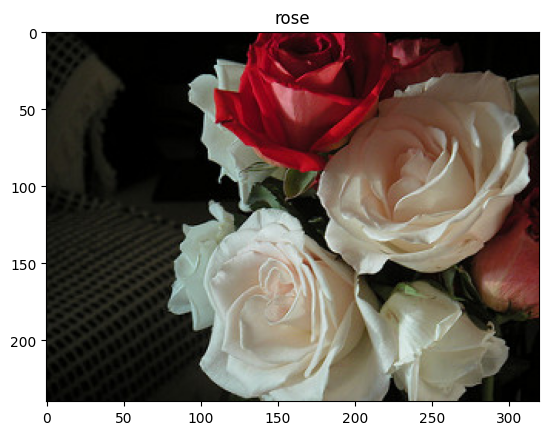

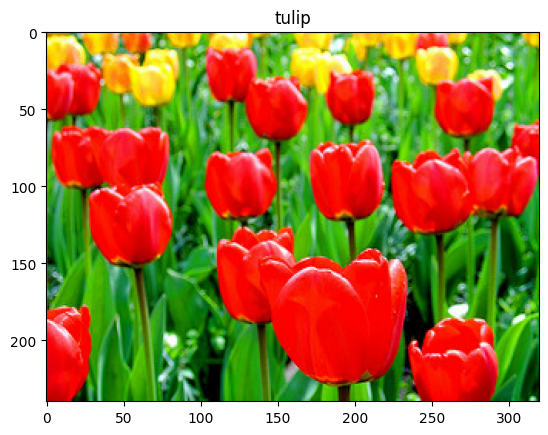

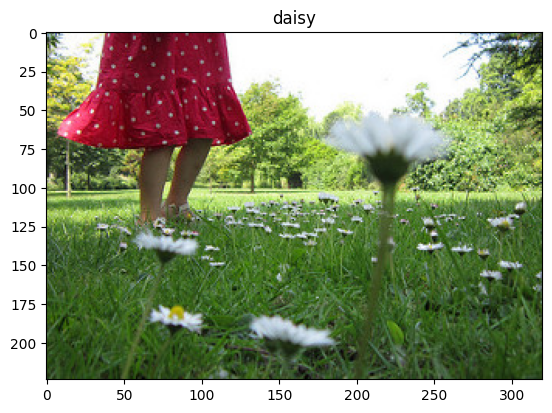

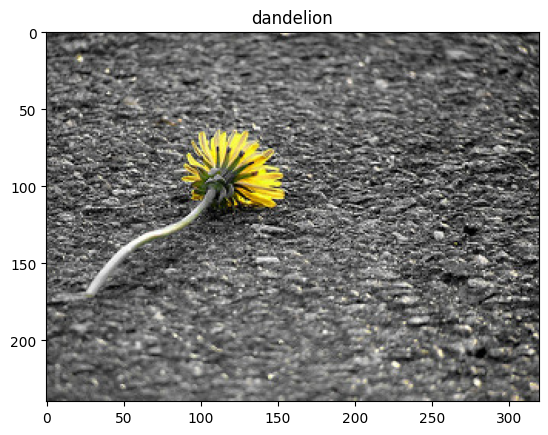

In [4]:
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

In [5]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [6]:
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [7]:
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [8]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

In [9]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [10]:
cnn_hist = cnn_model.fit(
    train_data,
    epochs=10,
    validation_data = valid_data
)

Epoch 1/10
109/109 [==============================] - 2034s 19s/step - loss: 1.3205 - accuracy: 0.3986 - val_loss: 1.1690 - val_accuracy: 0.4721
Epoch 2/10
109/109 [==============================] - 373s 3s/step - loss: 1.0916 - accuracy: 0.5647 - val_loss: 1.1861 - val_accuracy: 0.5616
Epoch 3/10
109/109 [==============================] - 387s 4s/step - loss: 1.0164 - accuracy: 0.5921 - val_loss: 1.0024 - val_accuracy: 0.5872
Epoch 4/10
109/109 [==============================] - 384s 4s/step - loss: 0.9516 - accuracy: 0.6245 - val_loss: 0.9294 - val_accuracy: 0.6326
Epoch 5/10
109/109 [==============================] - 369s 3s/step - loss: 0.8699 - accuracy: 0.6653 - val_loss: 0.9034 - val_accuracy: 0.6593
Epoch 6/10
109/109 [==============================] - 385s 4s/step - loss: 0.8688 - accuracy: 0.6662 - val_loss: 0.8760 - val_accuracy: 0.6802
Epoch 7/10
109/109 [==============================] - 372s 3s/step - loss: 0.8077 - accuracy: 0.6838 - val_loss: 0.8912 - val_accuracy: 0.67

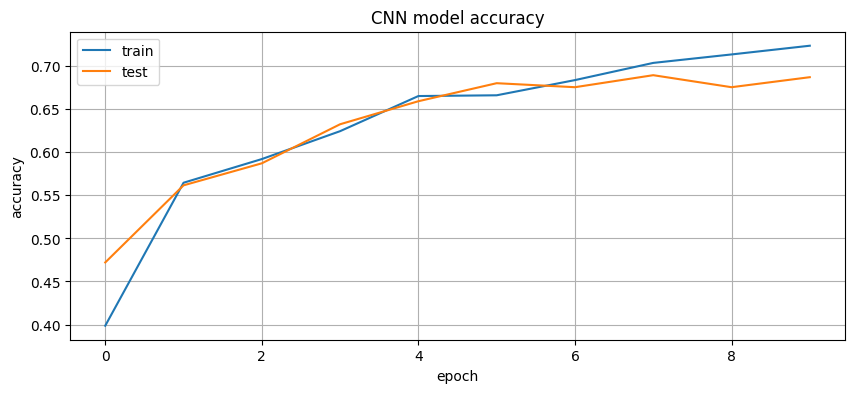

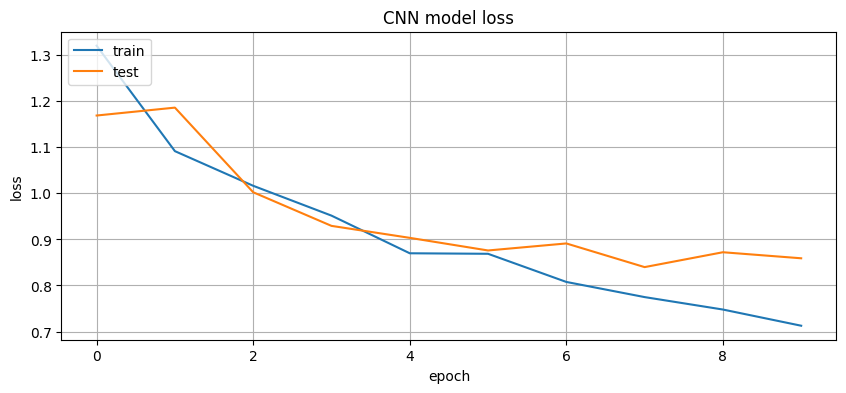

In [11]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess

58889256/58889256 [==============================] - 3s 0us/step


In [13]:
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [15]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=5,
    validation_data = valid_data
)

Epoch 1/5
109/109 [==============================] - 2185s 20s/step - loss: 0.6161 - accuracy: 0.7695 - val_loss: 0.6672 - val_accuracy: 0.7500
Epoch 2/5
109/109 [==============================] - 2170s 20s/step - loss: 0.6273 - accuracy: 0.7625 - val_loss: 0.5500 - val_accuracy: 0.8035
Epoch 3/5
109/109 [==============================] - 2149s 20s/step - loss: 0.5945 - accuracy: 0.7732 - val_loss: 0.5217 - val_accuracy: 0.8151
Epoch 4/5
109/109 [==============================] - 2133s 20s/step - loss: 0.5654 - accuracy: 0.7906 - val_loss: 0.5169 - val_accuracy: 0.8198
Epoch 5/5
109/109 [==============================] - 2130s 20s/step - loss: 0.5828 - accuracy: 0.7802 - val_loss: 0.5508 - val_accuracy: 0.8058


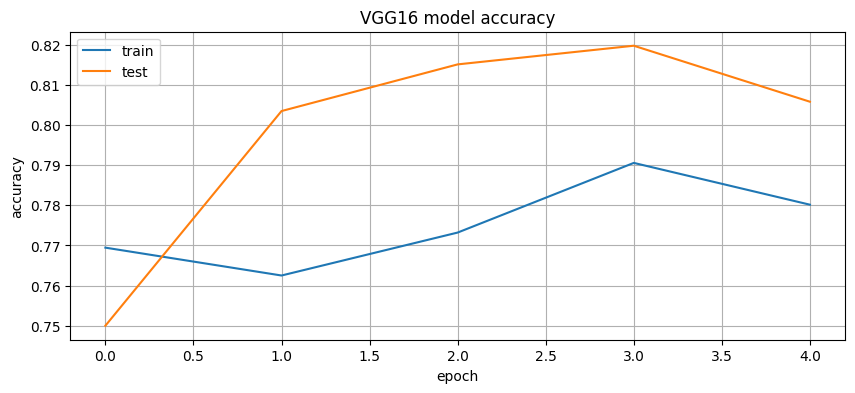

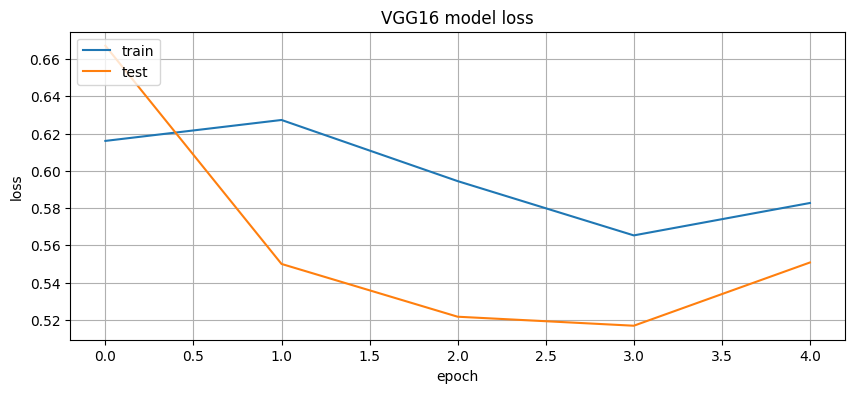

In [16]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [17]:
from tensorflow.keras.applications import ResNet50

# Loading ResNet50 model
base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=5,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input


# Transfer learning ResNet50
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])

94765736/94765736 [==============================] - 5s 0us/step


In [18]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [19]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=3,
    validation_data = valid_data
)

Epoch 1/3
109/109 [==============================] - 818s 7s/step - loss: 1.7053 - accuracy: 0.2852 - val_loss: 1.5238 - val_accuracy: 0.3326
Epoch 2/3
109/109 [==============================] - 804s 7s/step - loss: 1.5748 - accuracy: 0.2806 - val_loss: 1.5542 - val_accuracy: 0.3349
Epoch 3/3
109/109 [==============================] - 739s 7s/step - loss: 1.5382 - accuracy: 0.3246 - val_loss: 1.5148 - val_accuracy: 0.3407


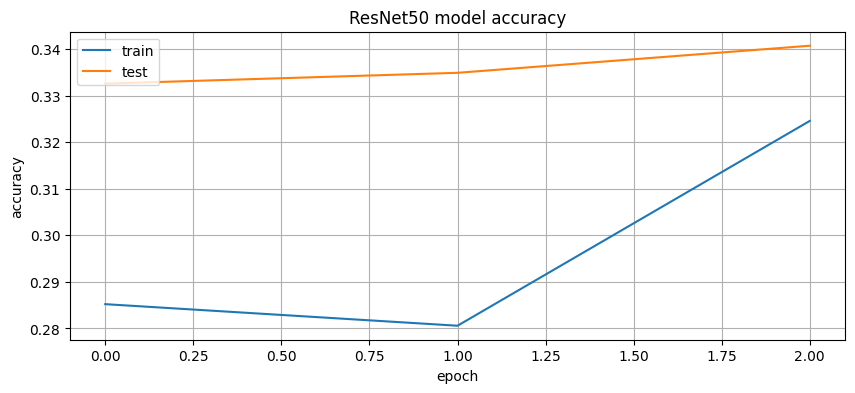

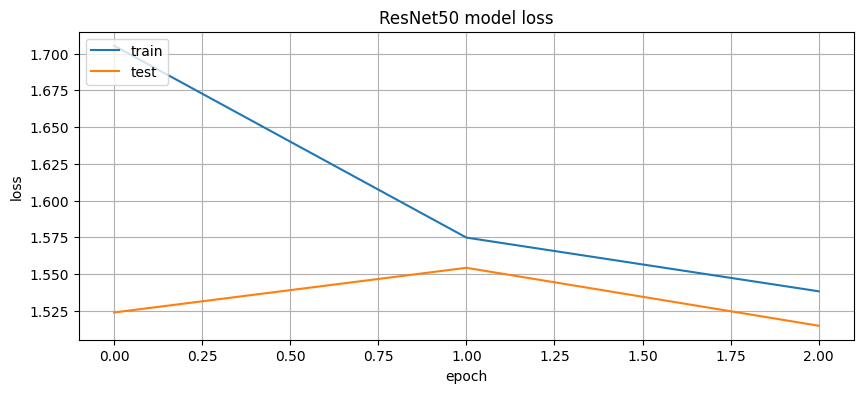

In [20]:
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()


In [21]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

74836368/74836368 [==============================] - 4s 0us/step


In [22]:
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [23]:
densenet_hist = densenet_model.fit(
    train_data,
    epochs=3,
    validation_data = valid_data
)

Epoch 1/3
109/109 [==============================] - 904s 8s/step - loss: 0.9735 - accuracy: 0.6387 - val_loss: 0.4315 - val_accuracy: 0.8581
Epoch 2/3
109/109 [==============================] - 915s 8s/step - loss: 0.5088 - accuracy: 0.8166 - val_loss: 0.3866 - val_accuracy: 0.8698
Epoch 3/3
109/109 [==============================] - 913s 8s/step - loss: 0.4357 - accuracy: 0.8377 - val_loss: 0.3325 - val_accuracy: 0.8860


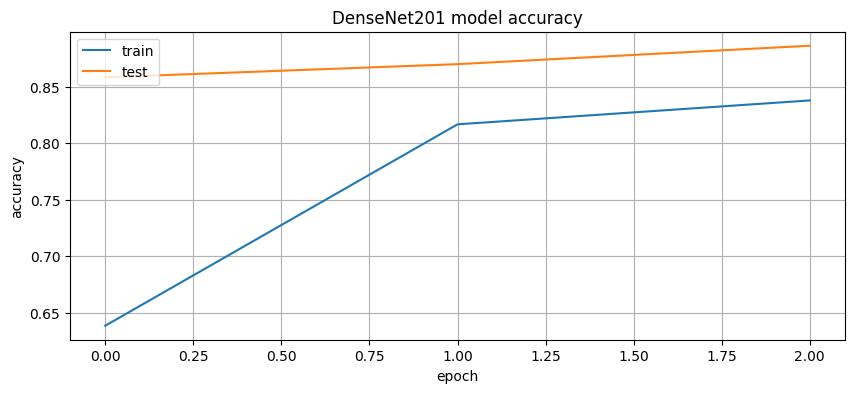

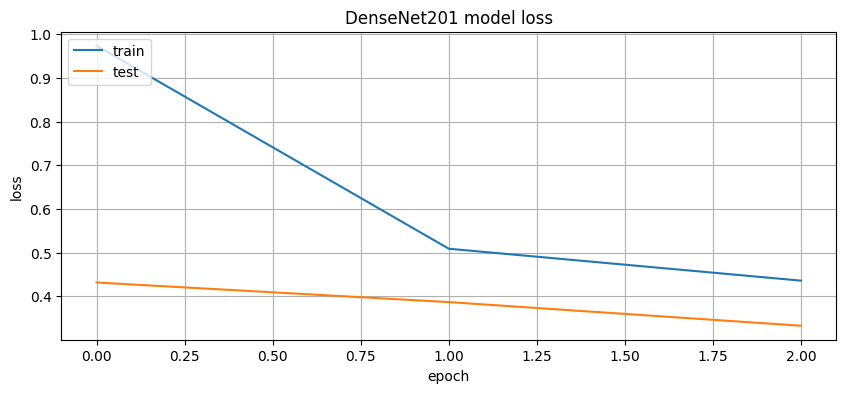

In [24]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

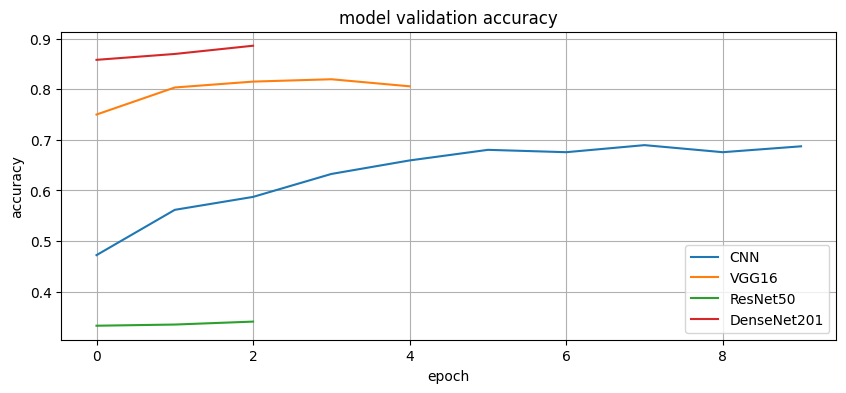

In [25]:
# Membuat plot akurasi empat model sebelumnya untuk dibandingkan
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet50', 'DenseNet201'], loc='lower right')
plt.grid(True)
plt.show()


In [26]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Saving 6953297_8576bf4ea3.jpg to 6953297_8576bf4ea3 (2).jpg
1/1 [==============================] - 4s 4s/step
6953297_8576bf4ea3.jpg
sunflower


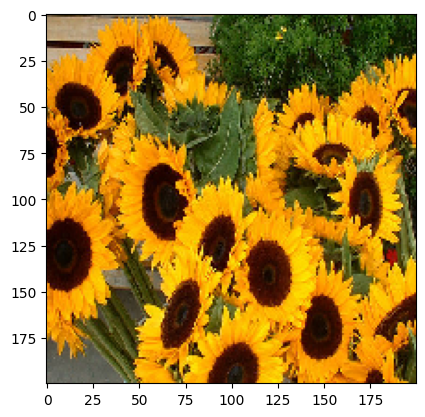

In [37]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
%matplotlib inline


#file upload, kode di bawah in hanya bisa dijalankan di google colab dengan mengimport from google.colab import files. Silahkan kalian ganti kodingannya agar bisa upload di jupyter notebook masing-masing
#atau kalian langsung import file gambarnya langsung
uploaded = files.upload()

for fn in uploaded.keys():

  # prediksi gambar
  path = fn
  img = load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = densenet_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)

  print(fn)
  if classes==0:
    print('daisy')
  elif classes==1:
    print('dandelion')
  elif classes==2:
    print('rose')
  elif classes==3:
    print('sunflower')
  else:
    print('tulip')

In [31]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.10
    Uninstalling flax-0.6.10:
      Successfully uninstalled flax-0.6.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.


In [32]:
pip install --upgrade packaging


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflowjs 4.8.0 requires packaging~=20.9, but you have packaging 23.1 which is incompatible.


In [33]:
pip install --upgrade statsmodels xarray


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.1/999.1 kB 41.1 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2022.12.0
    Uninstalling xarray-2022.12.0:
      Successfully uninstalled xarray-2022.12.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5


In [34]:
pip install --upgrade statsmodels xarray


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
